In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml as dml
import dask_ml.model_selection as dcv
from dask.diagnostics import ProgressBar

from sklearn.model_selection import train_test_split
import lightgbm as lgb

import random

import shap
shap.initjs()


import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import itertools
def plot_confusion_matrix(cm, cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([-0.5,1.5], [0,1], rotation=0)
#     plt.yticks(tick_marks, [0,1])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

In [24]:
#################################################################
##### Define a function to analyze the model performance ########
#################################################################

def perf_analysis(model, data, features, y_var, which_data = 'Train Set', cv = True):
    
    print('**************', 'Performance:', which_data, '****************', '\n')
    
    
    y_pred = model.predict(data[features])
    y_pred = y_pred.round(0)
    cnf_matrix = confusion_matrix(data[y_var], y_pred)
    plot_confusion_matrix(cnf_matrix)

    
    print("Accuracy:", round(accuracy_score(data[y_var], y_pred),2))
    print("Precision:", round(precision_score(data[y_var], y_pred),2))
    print("Recall:", round(recall_score(data[y_var], y_pred),2))
    print("F1:", round(f1_score(data[y_var], y_pred),2))

    if cv:
        # if the model comes from the cross validation, we need predict_proba, instead of predict
        fpr, tpr, thresholds = roc_curve(data[y_var], model.predict_proba(data[features])[:, 1])

    else: 
        fpr, tpr, thresholds = roc_curve(data[y_var], model.predict(data[features]))
    
    
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.figure(figsize = (8,6))
    plt.title(which_data+': ROC', fontsize = 15)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right', fontsize =15)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.show()

In [10]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'person',
    'offer_id',
    'time_received',
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]

modeling_data = modeling_data.sort_values(by = ['person', 'time_received']).reset_index(drop = True)
modeling_data['num_offers'] = modeling_data.groupby('person')['time_received'].transform(lambda group: group.astype('category').cat.codes + 1)
modeling_data.head()

,person,offer_id,time_received,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,channel_social,channel_web,gender,age,income,membership_days,membership_month,membership_year,successful_offer,num_offers
0,user_100,discount_10_5,0.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1940.0,7.0,2016.0,0,1.0
1,user_100,bogo_7_10,336.0,bogo,7.0,10,10,3,1,1,1,0,F,68.0,84000.0,1940.0,7.0,2016.0,0,2.0
2,user_100,informational_4,408.0,informational,4.0,0,0,3,1,1,0,1,F,68.0,84000.0,1940.0,7.0,2016.0,0,3.0
3,user_100,discount_10_5,576.0,discount,10.0,5,20,2,1,0,0,1,F,68.0,84000.0,1940.0,7.0,2016.0,0,4.0
4,user_1000,bogo_5_10,0.0,bogo,5.0,10,10,4,1,1,1,1,M,67.0,44000.0,1440.0,12.0,2017.0,0,1.0


In [11]:
modeling_data['membership_days_X_income'] = modeling_data['membership_days']*modeling_data['income']
modeling_data['num_channels_X_income'] = modeling_data['num_channels']*modeling_data['income']
modeling_data['age_X_income'] = modeling_data['age']*modeling_data['income']
modeling_data['membership_month_sin'] = np.sin(2 * np.pi * modeling_data['membership_month'] / 12)
modeling_data['membership_month_cos'] = np.cos(2 * np.pi * modeling_data['membership_month'] / 12)

In [12]:
# modeling_data.sample(50).plot.scatter('membership_month_sin','membership_month_cos').set_aspect('equal');


In [13]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
    'num_offers',
    'membership_days_X_income',
    'num_channels_X_income',
    'age_X_income',
    'membership_month_sin',
    'membership_month_cos',
    'difficulty',

]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
#     'difficulty',
    'gender', 
#     'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [14]:
for i in cat_vars:
    y = pd.get_dummies(modeling_data[i], prefix=i, drop_first=True)
    y = y.astype('int64')
    features = features + y.columns.tolist()
    features = [x for x in features if x != i]
    modeling_data = pd.concat([modeling_data, y], axis=1)

In [112]:
# Y = modeling_data[y_var].astype(str)
# train_val_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)
# Y = train_val_df[y_var].astype(str)
# train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=2021, stratify = Y)


# train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
# val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
# test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)


# scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
# print(scale_pos_weight_val)
# (len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

In [21]:
ID_list = modeling_data['person'].unique().tolist()
random.seed(2021)
train_IDs = random.sample(ID_list, int(0.8*len(ID_list)))

train_val_df = modeling_data[modeling_data['person'].isin(train_IDs)]
test_df = modeling_data[~modeling_data['person'].isin(train_IDs)]
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(modeling_data[y_var]), np.mean(train_val_df[y_var]), np.mean(test_df[y_var]))

ID_list = train_val_df['person'].unique().tolist()
random.seed(2021)
train_IDs = random.sample(ID_list, int(0.8*len(ID_list)))

train_df = train_val_df[train_val_df['person'].isin(train_IDs)]
val_df = train_val_df[~train_val_df['person'].isin(train_IDs)]
print(len(train_val_df)/len(modeling_data), len(test_df)/len(modeling_data))
print(np.mean(train_df[y_var]), np.mean(val_df[y_var]), np.mean(test_df[y_var]))

scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)

0.029119373776908025 0.029023197753042754 0.02899867812293457
33.34139784946237


In [17]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'num_offers',
 'membership_days_X_income',
 'num_channels_X_income',
 'age_X_income',
 'membership_month_sin',
 'membership_month_cos',
 'difficulty',
 'offer_id_bogo_5_5',
 'offer_id_bogo_7_10',
 'offer_id_bogo_7_5',
 'offer_id_discount_10_2',
 'offer_id_discount_10_5',
 'offer_id_discount_7_2',
 'offer_id_discount_7_3',
 'offer_id_informational_3',
 'offer_id_informational_4',
 'offer_type_discount',
 'offer_type_informational',
 'offer_reward_2',
 'offer_reward_3',
 'offer_reward_5',
 'offer_reward_10',
 'gender_M',
 'gender_O',
 'membership_year_2014.0',
 'membership_year_2015.0',
 'membership_year_2016.0',
 'membership_year_2017.0',
 'membership_year_2018.0']

In [19]:
from xgboost import XGBRegressor, XGBClassifier


In [22]:

# {'learning_rate': 0.38843123678890507,
#  'n_estimators': 263,
#  'max_depth': 12,
#  'subsample': 0.929705799396118,
#  'colsample_bytree': 0.6099990449863144,
#  'min_child_weight': 50}

xgb_model = XGBClassifier(
    objective = 'binary:logistic', 
    use_label_encoder=False, 
    silent=True, 
    verbosity = 0,
    random_state=2021, 
    n_jobs= -1,
    booster = 'gbtree', 
    
    learning_rate = 0.38843123678890507,
    n_estimators = 263, 
    max_depth = 12, 
    subsample = 0.929705799396118,
    colsample_bytree = 0.6099990449863144, 
    min_child_weight = 50, 
    scale_pos_weight = scale_pos_weight_val, 
)

In [23]:
xgb_model.fit(train_val_df[features], train_val_df[y_var])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6099990449863144, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.38843123678890507, max_delta_step=0, max_depth=12,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=263, n_jobs=-1, num_parallel_tree=1,
              random_state=2021, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=33.34139784946237, silent=True,
              subsample=0.929705799396118, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

************** Performance: Train Set **************** 



Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Accuracy: 0.98
Precision: 0.54
Recall: 1.0
F1: 0.7


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


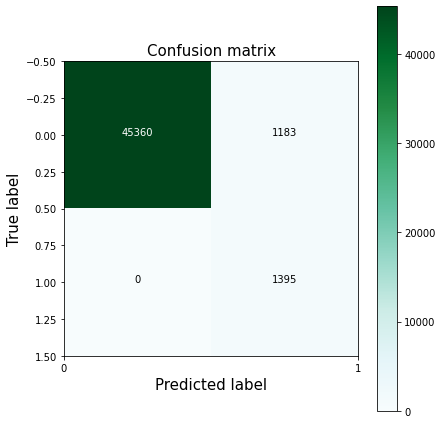

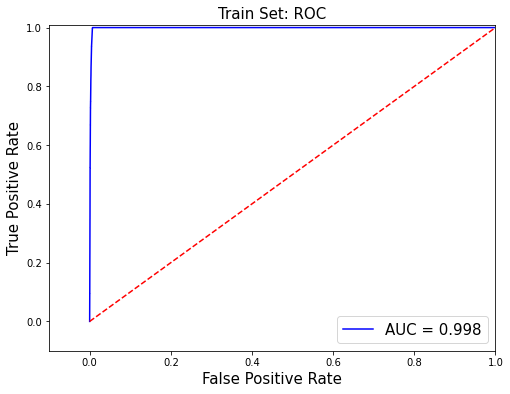

************** Performance: Test Set **************** 

Accuracy: 0.94
Precision: 0.06
Recall: 0.08
F1: 0.07


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


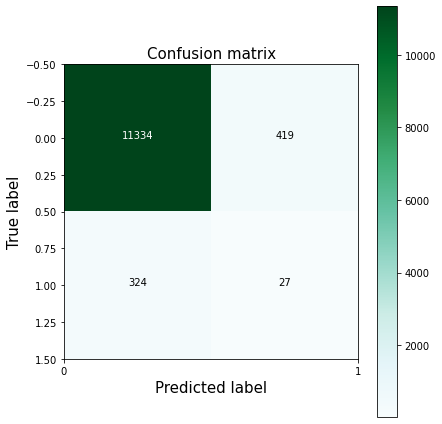

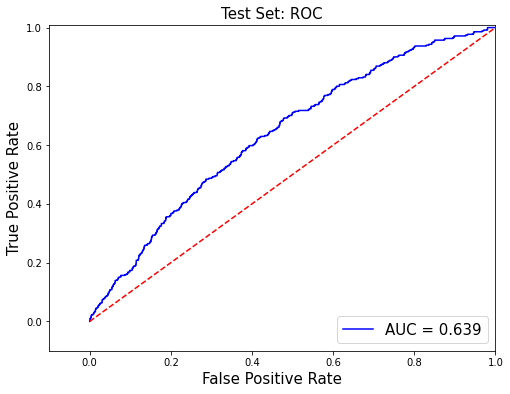

In [25]:
perf_analysis(model = xgb_model, data = train_val_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = xgb_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [27]:
import optuna
from optuna.samplers import TPESampler

In [48]:
sampler = TPESampler(seed=2021)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")

[I 2021-11-23 12:51:50,790] A new study created in memory with name: no-name-033df1df-cf80-4f6a-8ad7-9d95ec173dfa


Sampler is TPESampler


In [49]:
# We define the objective function! 
def objective(trial):
    
    
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.4, log = True)
    gamma = trial.suggest_float("gamma", 1e-3, 10, log = True)
    n_estimators = trial.suggest_int("n_estimators", 1000, 2000)
    max_depth = trial.suggest_int("max_depth", 2, 12)
    subsample = trial.suggest_float("subsample", 0.5,1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    min_child_weight = trial.suggest_int("min_child_weight", 10, 500)
    reg_alpha = trial.suggest_float("reg_alpha", 1e-3, 10, log = True)
    reg_lambda = trial.suggest_float("reg_lambda", 1e-3, 10, log = True)
    
    params ={
        'objective' : 'binary:logistic', 
        'use_label_encoder':False, 
        'silent':True, 
        'verbosity' : 0,
        'random_state':2021, 
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight_val, 
        'learning_rate': learning_rate,
        'gamma': gamma,
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'subsample': subsample,
        'colsample_bytree':colsample_bytree,
        'min_child_weight': min_child_weight,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda
        
            }
    

    model = XGBClassifier(
        **params     
    )

    model.fit(train_df[features], train_df[y_var])
    
    y_pred = model.predict(val_df[features])

    f1_score_val = f1_score(val_df[y_var], y_pred)

    return f1_score_val

In [53]:
study.optimize(objective,n_trials=100)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:23:09,939] Trial 100 finished with value: 0.10846812559467175 and parameters: {'learning_rate': 0.04859065328872034, 'gamma': 0.0013512985926325074, 'n_estimators': 1524, 'max_depth': 12, 'subsample': 0.640611767523836, 'colsample_bytree': 0.5983709257279173, 'min_child_weight': 460, 'reg_alpha': 0.011855210508217136, 'reg_lambda': 6.457077024796112}. Best is trial 96 with value: 0.11715089034676664.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:23:27,031] Trial 101 finished with value: 0.11343012704174228 and parameters: {'learning_rate': 0.03690664147697501, 'gamma': 0.0011856624724600412, 'n_estimators': 1471, 'max_depth': 12, 'subsample': 0.7103821667160027, 'colsample_bytree': 0.5526798632893404, 'min_child_weight': 478, 'reg_alpha': 0.06003

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:27:21,997] Trial 115 finished with value: 0.11170471102476931 and parameters: {'learning_rate': 0.05468618395126954, 'gamma': 0.002384740070924921, 'n_estimators': 1459, 'max_depth': 12, 'subsample': 0.587389270949443, 'colsample_bytree': 0.6861993668554823, 'min_child_weight': 448, 'reg_alpha': 0.012726009757713331, 'reg_lambda': 2.9519980292140167}. Best is trial 102 with value: 0.11781472684085512.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:27:47,938] Trial 116 finished with value: 0.08308605341246292 and parameters: {'learning_rate': 0.045429958182751674, 'gamma': 0.0038125471293265606, 'n_estimators': 1396, 'max_depth': 12, 'subsample': 0.643963992175411, 'colsample_bytree': 0.6156768797255369, 'min_child_weight': 51, 'reg_alpha': 0.02381

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:31:57,753] Trial 130 finished with value: 0.11069805865344899 and parameters: {'learning_rate': 0.017835457410110316, 'gamma': 0.4215079122050415, 'n_estimators': 1649, 'max_depth': 12, 'subsample': 0.652108393180226, 'colsample_bytree': 0.6193964410425044, 'min_child_weight': 425, 'reg_alpha': 0.011693281569655305, 'reg_lambda': 1.8003359027879686}. Best is trial 121 with value: 0.11821366024518389.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:32:15,377] Trial 131 finished with value: 0.11582670203359857 and parameters: {'learning_rate': 0.034692465520531686, 'gamma': 0.22955189204031123, 'n_estimators': 1479, 'max_depth': 11, 'subsample': 0.6957353789603923, 'colsample_bytree': 0.7425448434961692, 'min_child_weight': 500, 'reg_alpha': 0.024355

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:36:30,242] Trial 145 finished with value: 0.11404335532516492 and parameters: {'learning_rate': 0.04051869368040304, 'gamma': 0.11812988862911733, 'n_estimators': 1480, 'max_depth': 12, 'subsample': 0.6978873902933254, 'colsample_bytree': 0.783619526629891, 'min_child_weight': 469, 'reg_alpha': 0.03476519077821182, 'reg_lambda': 0.8070923111715894}. Best is trial 121 with value: 0.11821366024518389.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:36:48,208] Trial 146 finished with value: 0.11580322159338267 and parameters: {'learning_rate': 0.02732206660938164, 'gamma': 0.3889476004044715, 'n_estimators': 1441, 'max_depth': 11, 'subsample': 0.7142114367013587, 'colsample_bytree': 0.74462497827081, 'min_child_weight': 485, 'reg_alpha': 0.02022878660

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:41:12,064] Trial 160 finished with value: 0.10542168674698796 and parameters: {'learning_rate': 0.028272570373527994, 'gamma': 1.0124901379176185, 'n_estimators': 1444, 'max_depth': 10, 'subsample': 0.7058444670724282, 'colsample_bytree': 0.7293389553704885, 'min_child_weight': 340, 'reg_alpha': 0.011932730552377608, 'reg_lambda': 0.29361533926593364}. Best is trial 157 with value: 0.11822660098522166.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:41:31,547] Trial 161 finished with value: 0.11327433628318584 and parameters: {'learning_rate': 0.023174989776200673, 'gamma': 0.6501995944932923, 'n_estimators': 1478, 'max_depth': 11, 'subsample': 0.722600765961262, 'colsample_bytree': 0.7440693183880139, 'min_child_weight': 432, 'reg_alpha': 0.015072

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:45:33,647] Trial 175 finished with value: 0.11467268623024832 and parameters: {'learning_rate': 0.03940165935491042, 'gamma': 0.29524293239314675, 'n_estimators': 1444, 'max_depth': 11, 'subsample': 0.6587042411207918, 'colsample_bytree': 0.5689938791064333, 'min_child_weight': 464, 'reg_alpha': 0.22968027527951837, 'reg_lambda': 2.348830549191568}. Best is trial 157 with value: 0.11822660098522166.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:45:51,860] Trial 176 finished with value: 0.11025537089582489 and parameters: {'learning_rate': 0.02294844656434191, 'gamma': 0.0014321542082006253, 'n_estimators': 1506, 'max_depth': 11, 'subsample': 0.644426396214982, 'colsample_bytree': 0.7941297403832931, 'min_child_weight': 491, 'reg_alpha': 0.0473915

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:50:00,854] Trial 190 finished with value: 0.11181818181818182 and parameters: {'learning_rate': 0.02886903506086539, 'gamma': 0.0027457670008872396, 'n_estimators': 1416, 'max_depth': 11, 'subsample': 0.7041483851440172, 'colsample_bytree': 0.7121901548602729, 'min_child_weight': 420, 'reg_alpha': 0.020895753614601036, 'reg_lambda': 1.2731831369713573}. Best is trial 157 with value: 0.11822660098522166.
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
[I 2021-11-23 13:50:18,428] Trial 191 finished with value: 0.11373209772535806 and parameters: {'learning_rate': 0.023847896166258587, 'gamma': 0.0011524385790041129, 'n_estimators': 1437, 'max_depth': 12, 'subsample': 0.6733270784570234, 'colsample_bytree': 0.6994658616517054, 'min_child_weight': 469, 'reg_alpha': 0.0

In [54]:
study.best_params

{'learning_rate': 0.031431238016023884,
 'gamma': 0.5382982588253525,
 'n_estimators': 1442,
 'max_depth': 11,
 'subsample': 0.6908787360954459,
 'colsample_bytree': 0.7208257536551563,
 'min_child_weight': 459,
 'reg_alpha': 0.01969921480151456,
 'reg_lambda': 1.3791390857055732}

Optuna best performance = 0.1182


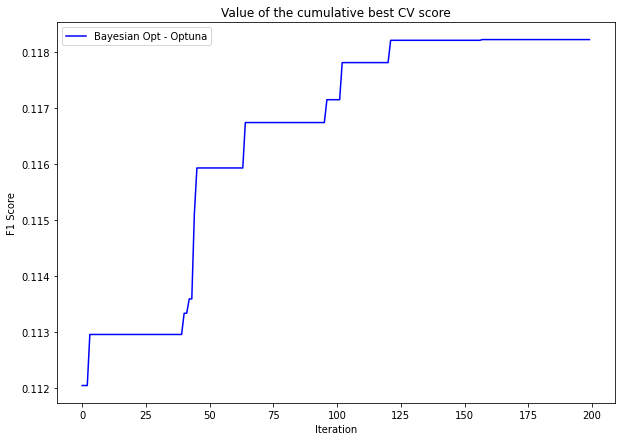

In [55]:
op_tuna_cummax = np.array(study.trials_dataframe()["value"].cummax()) 
print(f'Optuna best performance = {op_tuna_cummax[-1]:.4f}')
fig = plt.figure(figsize = (10, 7))
plt.plot(op_tuna_cummax, 'b', label='Bayesian Opt - Optuna')
# plt.plot(y_bo, 'r', label='Bayesian Opt - implementation')
# plt.plot(y_rs, 'g', label='Random search')

plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('Value of the cumulative best CV score');
plt.legend()

In [56]:
best = {'learning_rate': 0.031431238016023884,
 'gamma': 0.5382982588253525,
 'n_estimators': 1442,
 'max_depth': 11,
 'subsample': 0.6908787360954459,
 'colsample_bytree': 0.7208257536551563,
 'min_child_weight': 459,
 'reg_alpha': 0.01969921480151456,
 'reg_lambda': 1.3791390857055732}

params ={
    'objective' : 'binary:logistic', 
    'use_label_encoder':False, 
    'silent':True, 
    'verbosity' : 0,
    'random_state':2021, 
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight_val, 
    'learning_rate': best['learning_rate'],
    'gamma': best['gamma'],
    'n_estimators': best['n_estimators'],
    'max_depth': best['max_depth'],
    'subsample': best['subsample'],
    'colsample_bytree':best['colsample_bytree'],
    'min_child_weight': best['min_child_weight'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
    
        }


model = XGBClassifier(
    **params     
)

model.fit(train_val_df[features], train_val_df[y_var])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7208257536551563,
              gamma=0.5382982588253525, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.031431238016023884,
              max_delta_step=0, max_depth=11, min_child_weight=459, missing=nan,
              monotone_constraints='()', n_estimators=1442, n_jobs=-1,
              num_parallel_tree=1, random_state=2021,
              reg_alpha=0.01969921480151456, reg_lambda=1.3791390857055732,
              scale_pos_weight=33.34139784946237, silent=True,
              subsample=0.6908787360954459, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

************** Performance: Train Set **************** 



Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


Accuracy: 0.98
Precision: 0.54
Recall: 1.0
F1: 0.7


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


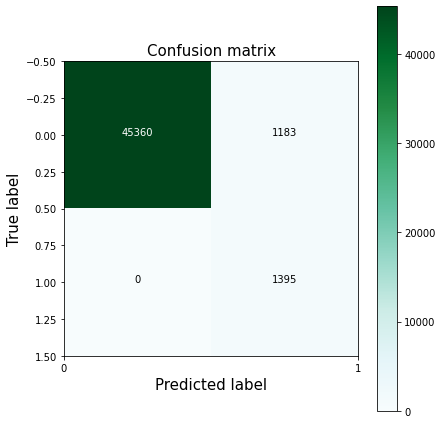

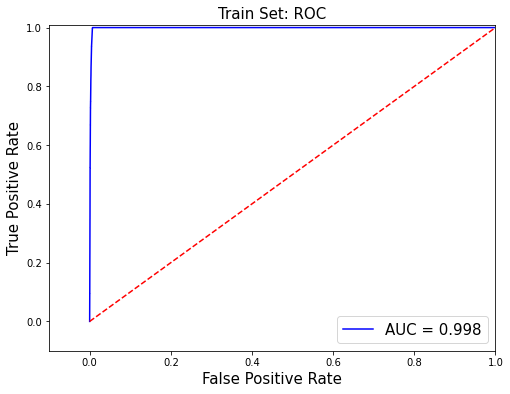

************** Performance: Test Set **************** 

Accuracy: 0.94
Precision: 0.06
Recall: 0.08
F1: 0.07


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


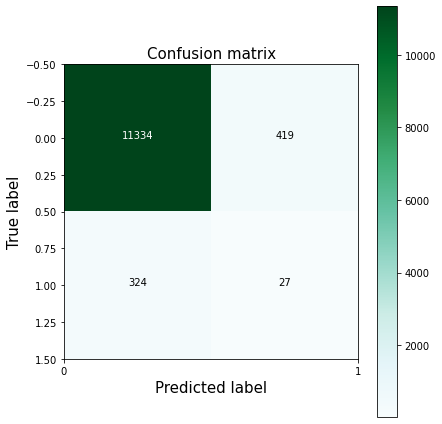

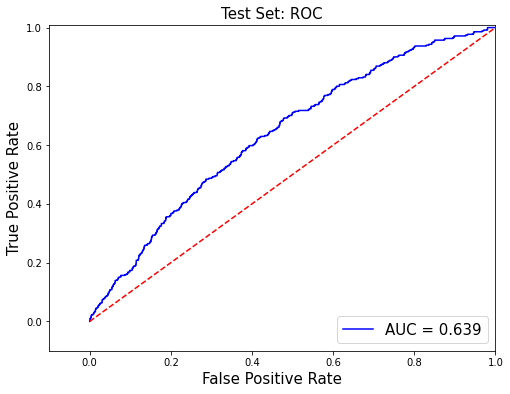

In [57]:
perf_analysis(model = xgb_model, data = train_val_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = xgb_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [116]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


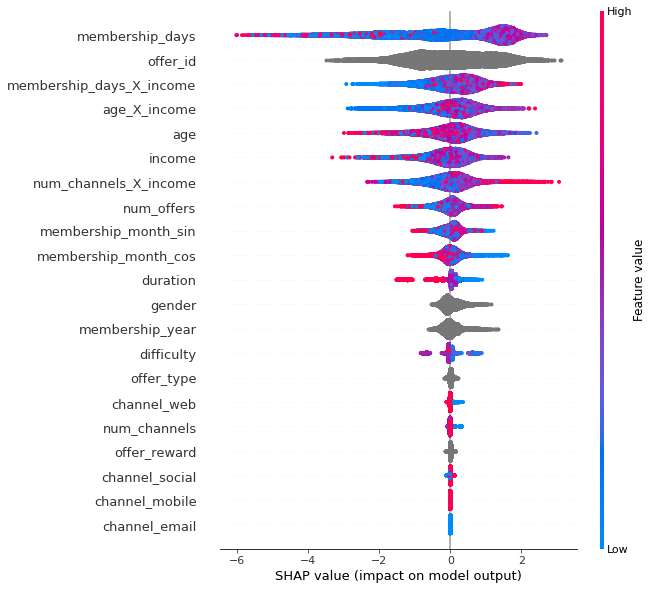

In [117]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)


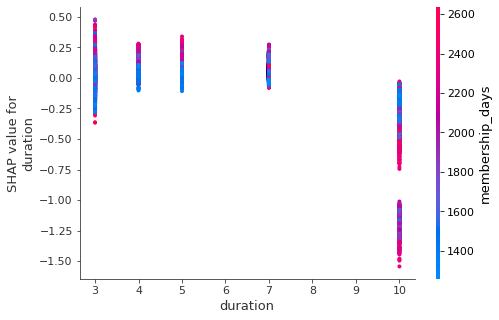

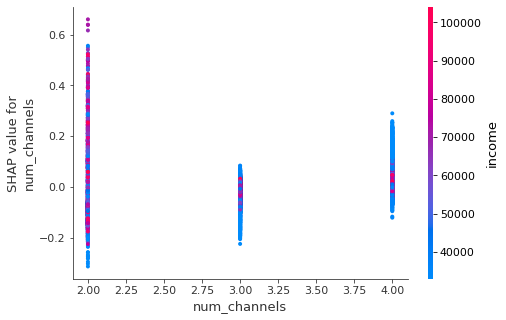

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


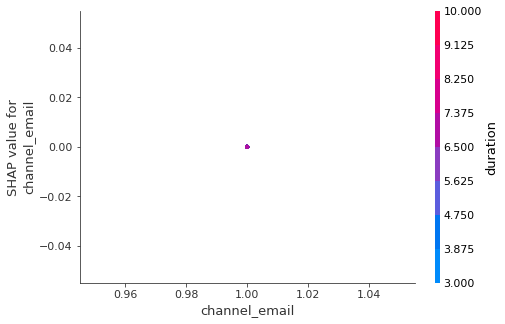

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


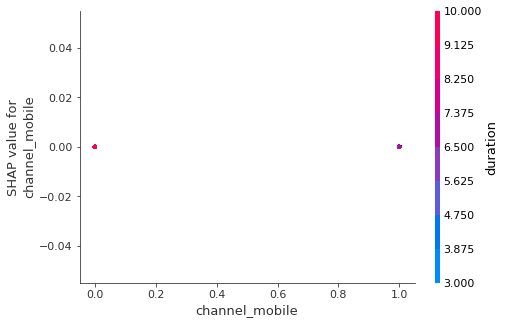

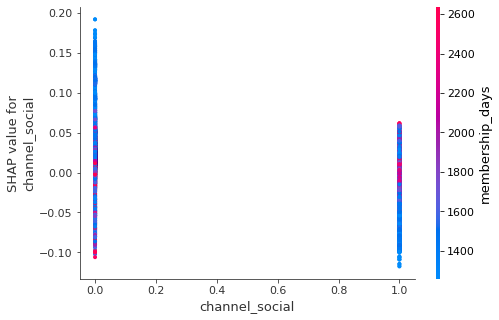

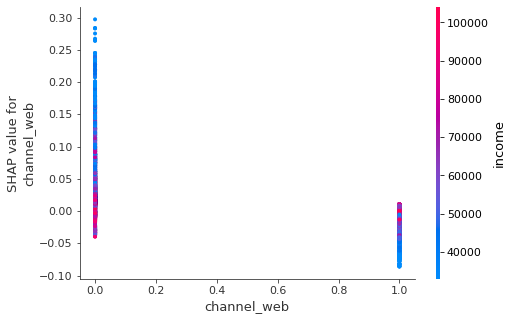

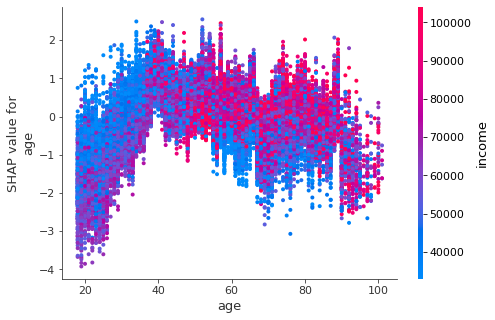

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


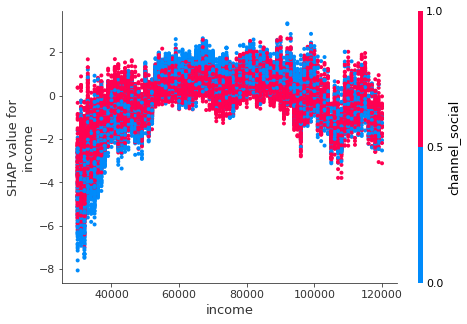

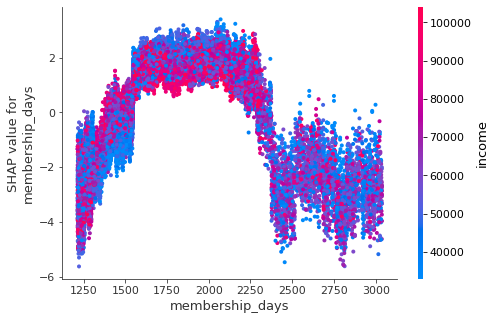

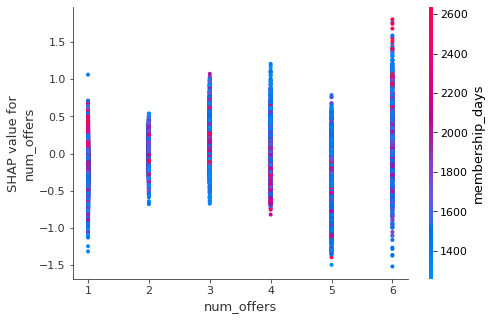

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


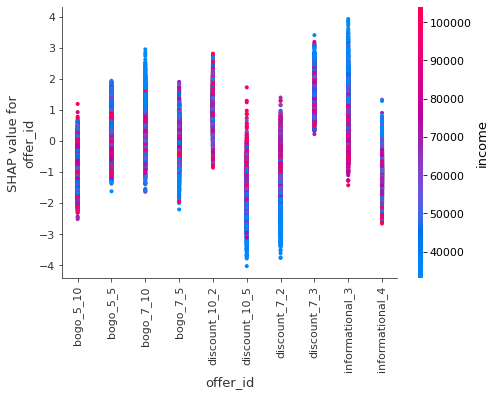

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


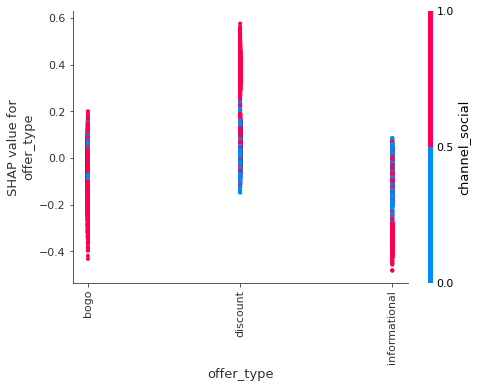

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


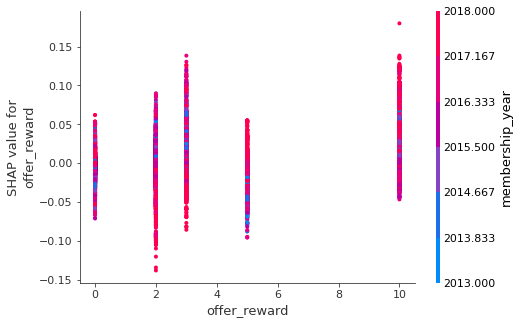

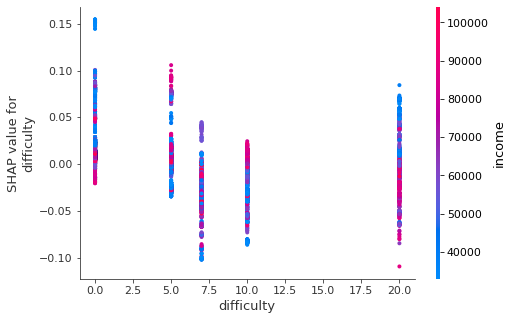

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


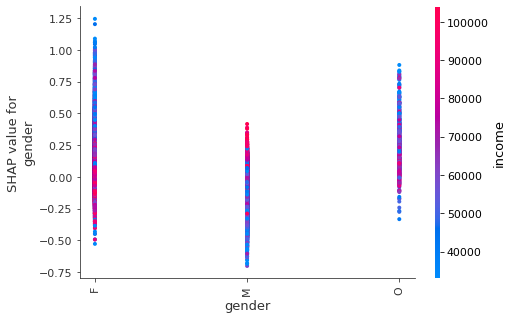

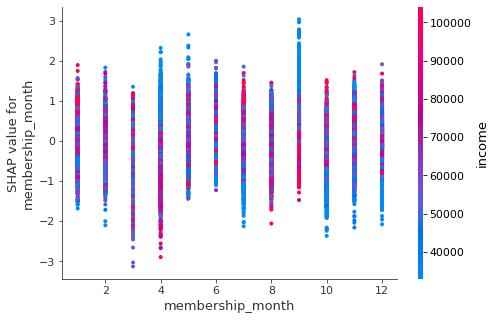

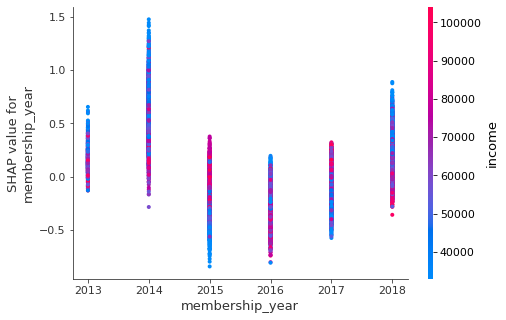

In [20]:
for name in features:
    shap.dependence_plot(name, shap_values[1], train_df[features])

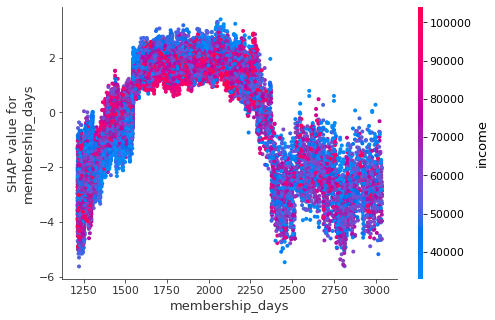

In [21]:
shap.dependence_plot('membership_days', shap_values[1], train_df[features]) #, display_features=train_df)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


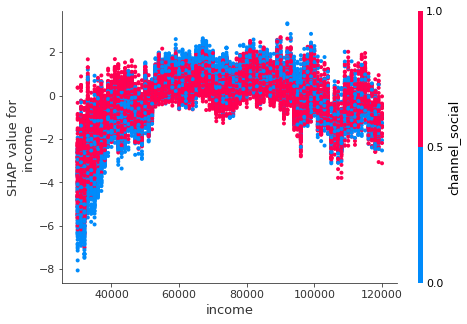

In [22]:
shap.dependence_plot('income', shap_values[1], train_df[features]) #, display_features=train_df)

In [55]:
scale_pos_weight_val = (len(train_val_df)-sum(train_val_df[y_var]))/sum(train_val_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

33.36415770609319


33.484330484330485

In [62]:
param_test ={'max_depth':[3,5,8,10],
    'num_leaves': [5,10,20, 30], 
             'min_child_samples': [10, 100, 500], 
             'reg_alpha': [0, 1e-2, 1e-1, 1],
             'reg_lambda': [0, 1e-2, 1e-1, 1],
             'scale_pos_weight': [scale_pos_weight_val]
            }

In [39]:
gbm_model = lgb.LGBMClassifier(objective = "binary", metric = ['auc', 'binary_error'], random_state=2021, verbose=-1, n_jobs=-1, n_estimators=500)
gbm_gs = dcv.GridSearchCV(
    estimator=gbm_model, param_grid=param_test, 
    scoring='f1',
    cv=5,
    refit=True,
)

In [40]:
with ProgressBar():
    gbm_gs.fit(train_df[features], train_df[y_var])

[########################################] | 100% Completed |  4hr 55min 39.7s
[########################################] | 100% Completed |  1min 20.4s


In [41]:
print('Best score reached: {} with params: {} '.format(gbm_gs.best_score_, gbm_gs.best_params_))

Best score reached: 0.11354662934428611 with params: {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 


In [ ]:
# Best score reached: 0.11354662934428611 with params: 
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

In [42]:
y_train_pred = gbm_gs.predict(train_df[features])
y_train_pred = y_train_pred.round(0)
cnf_matrix_train = confusion_matrix(train_df[y_var], y_train_pred)
plot_confusion_matrix(cnf_matrix_train)

In [43]:
print('Performance: Train set \n')
print("Accuracy:", round(accuracy_score(train_df[y_var], y_train_pred),2))
print("Precision:", round(precision_score(train_df[y_var], y_train_pred),2))
print("Recall:", round(recall_score(train_df[y_var], y_train_pred),2))
print("F1:", round(f1_score(train_df[y_var], y_train_pred),2))

Performance: Train set 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


In [44]:
y_test_pred = gbm_gs.predict(test_df[features])
y_test_pred = y_test_pred.round(0)
cnf_matrix = confusion_matrix(test_df[y_var], y_test_pred)
plot_confusion_matrix(cnf_matrix)

In [45]:
print('Performance: Test set \n')
print("Accuracy:", round(accuracy_score(test_df[y_var], y_test_pred),2))
print("Precision:", round(precision_score(test_df[y_var], y_test_pred), 2))
print("Recall:", round(recall_score(test_df[y_var], y_test_pred),2))
print("F1:", round(f1_score(test_df[y_var], y_test_pred),2))

Performance: Test set 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


In [14]:
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 
param_test ={'max_depth':[5],
    'num_leaves': [10], 
             'min_child_samples': [200], 
             'reg_alpha': [0.01],
             'reg_lambda': [1],
             'scale_pos_weight': [37.552011095700415],
             'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2]

            }

In [15]:
gbm_model = lgb.LGBMClassifier(objective = "binary", metric = ['auc', 'binary_error'], random_state=2021, verbose=-1, n_jobs=-1, n_estimators=1000)
gbm_gs = dcv.GridSearchCV(
    estimator=gbm_model, param_grid=param_test, 
    scoring='f1',
    cv=5,
    refit=True,
)

In [16]:
with ProgressBar():
    gbm_gs.fit(train_df[features], train_df[y_var])

[########################################] | 100% Completed |  1min 58.3s
[########################################] | 100% Completed |  8.0s


In [17]:
print('Best score reached: {} with params: {} '.format(gbm_gs.best_score_, gbm_gs.best_params_))

Best score reached: 0.11354662934428611 with params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 


In [ ]:
# Best score reached: 0.11354662934428611 with params: 
# {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

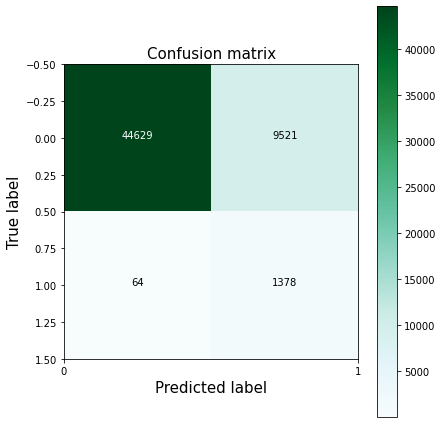

In [18]:
y_train_pred = gbm_gs.predict(train_df[features])
y_train_pred = y_train_pred.round(0)
cnf_matrix_train = confusion_matrix(train_df[y_var], y_train_pred)
plot_confusion_matrix(cnf_matrix_train)

In [19]:
print('Performance: Train set \n')
print("Accuracy:", round(accuracy_score(train_df[y_var], y_train_pred),2))
print("Precision:", round(precision_score(train_df[y_var], y_train_pred),2))
print("Recall:", round(recall_score(train_df[y_var], y_train_pred),2))
print("F1:", round(f1_score(train_df[y_var], y_train_pred),2))

Performance: Train set 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


In [34]:
y_test_pred = gbm_gs.predict(test_df[features])
y_test_pred = y_test_pred.round(0)
cnf_matrix = confusion_matrix(test_df[y_var], y_test_pred)
plot_confusion_matrix(cnf_matrix)

NameError: name 'gbm_gs' is not defined

In [21]:
print('Performance: Test set \n')
print("Accuracy:", round(accuracy_score(test_df[y_var], y_test_pred),2))
print("Precision:", round(precision_score(test_df[y_var], y_test_pred), 2))
print("Recall:", round(recall_score(test_df[y_var], y_test_pred),2))
print("F1:", round(f1_score(test_df[y_var], y_test_pred),2))

Performance: Test set 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


In [18]:
Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

33.38296349319971


In [19]:
# mc = [1 for f in cont_vars]+[None for f in cat_vars]
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

params = {'objective': "binary", 'metric': ['auc', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
          'max_depth': 5, 
          'min_child_samples': 200, 
          'num_leaves': 10, 
          'reg_alpha': 0.01, 
          'reg_lambda': 1, 
          'scale_pos_weight': scale_pos_weight_val,
          'n_estimators': 1000,
#           'feature_fraction':0.8
#           'bagging_freq': 10,
#           'bagging_fraction': 0.8
#           'learning_rate': 0.1
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[train_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400,
                     )

/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['difficulty', 'gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']
  _log_warning('categorical_feature in Dataset

Training until validation scores don't improve for 400 rounds


KeyboardInterrupt: 

************** Performance: Train Set **************** 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


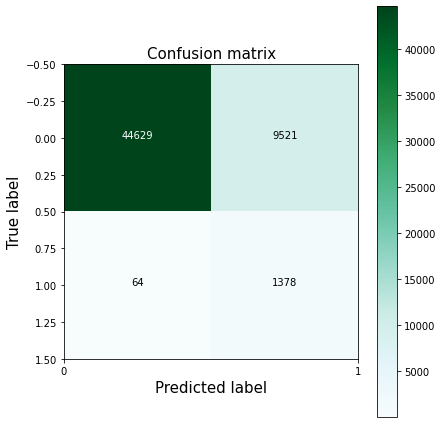

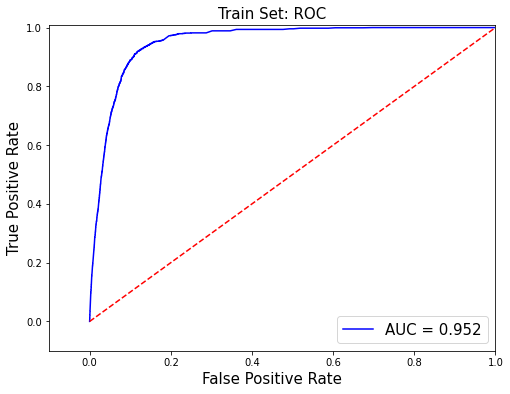

************** Performance: Test Set **************** 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


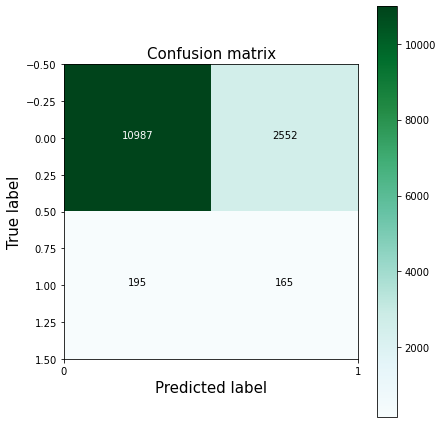

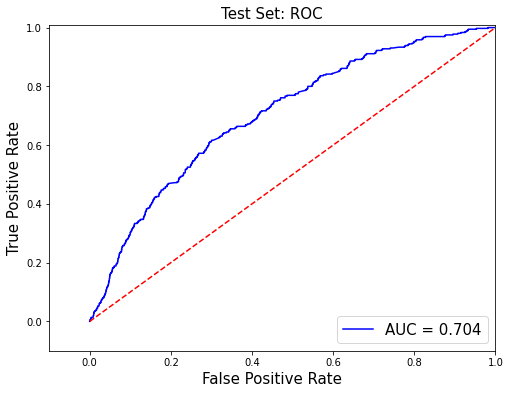

In [12]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [13]:
train_df.head()

,offer_id,offer_type,duration,offer_reward,difficulty,num_channels,channel_email,channel_mobile,channel_social,channel_web,gender,age,income,membership_days,membership_month,membership_year,successful_offer
55304,discount_10_2,discount,10.0,2,10,4,1,1,1,1,F,48.0,63000.0,1652.0,5.0,2017.0,0
26483,bogo_7_10,bogo,7.0,10,10,3,1,1,1,0,M,43.0,42000.0,1408.0,1.0,2018.0,0
17963,bogo_7_10,bogo,7.0,10,10,3,1,1,1,0,F,76.0,80000.0,2003.0,5.0,2016.0,0
7101,discount_10_5,discount,10.0,5,20,2,1,0,0,1,M,19.0,46000.0,2105.0,2.0,2016.0,0
8676,discount_10_5,discount,10.0,5,20,2,1,0,0,1,F,54.0,48000.0,2556.0,11.0,2014.0,0


In [14]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [15]:
import shap as shap
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], train_df[features].iloc[:100,:])


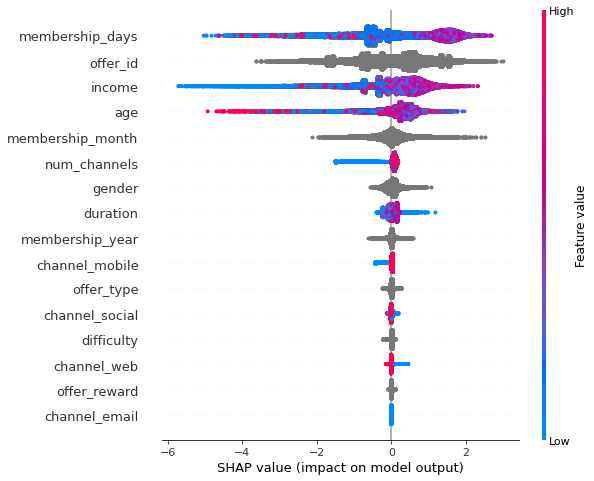

In [18]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)


In [21]:
shap.dependence_plot('income', shap_values[1], train_df[features]) #, display_features=train_df)

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
for name in features:
    shap.dependence_plot(name, shap_values[1], train_df[features])#, display_features=X_display)

In [50]:
name

'duration'

In [52]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [20]:
print(shap.__version__)

0.39.0


In [91]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'offer_id', 
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]
df.head()

,person,offer_id,original_reward,time_received,duration,time_viewed,time_completed,reward,successful_offer,tried_offer,...,membership_month,membership_year,offer_type,num_channels,offer_reward,difficulty,channel_email,channel_mobile,channel_social,channel_web
0,user_100,bogo_7_10,0.0,336.0,7.0,NaN,NaN,NaN,0,0,...,7.0,2016.0,bogo,3,10,10,1,1,1,0
1,user_100,discount_10_5,0.0,0.0,10.0,NaN,NaN,NaN,0,0,...,7.0,2016.0,discount,2,5,20,1,0,0,1
2,user_100,discount_10_5,0.0,576.0,10.0,NaN,NaN,NaN,0,0,...,7.0,2016.0,discount,2,5,20,1,0,0,1
3,user_100,informational_4,0.0,408.0,4.0,NaN,NaN,NaN,0,0,...,7.0,2016.0,informational,3,0,0,1,1,0,1
4,user_10002,informational_4,0.0,336.0,4.0,NaN,NaN,NaN,0,0,...,11.0,2015.0,informational,3,0,0,1,1,0,1


In [92]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
        'difficulty',
        'membership_month', 


]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
#     'membership_month', 
    'membership_year',
#     'membership_deciles'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [93]:
modeling_data['income_X_age'] = modeling_data['income']*modeling_data['age']


Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33.38296349319971


33.40974212034384

In [94]:
# Find the decile cuts in the train data and apply it to the test data, to avoid data leakage
train_df.loc[:, 'membership_deciles'] = pd.qcut(train_df['membership_days'],  q = 10,  duplicates = 'drop', labels = np.arange(1,11,1))
# train_df.loc[:, 'membership_deciles'] = train_df['membership_deciles'].astype(str)
bid_cuts = train_df.groupby(['membership_deciles'])[['membership_days']].min().reset_index()
bid_cuts.columns = ['membership_deciles', 'min_val']
temp = train_df.groupby(['membership_deciles'])[['membership_days']].max().reset_index()
temp.columns = ['membership_deciles', 'max_val']
bid_cuts = bid_cuts.merge(temp, on = ['membership_deciles'])
bid_cuts['membership_deciles'] = bid_cuts['membership_deciles'].astype(int)
bid_cuts = bid_cuts.sort_values(by = ['membership_deciles']).reset_index(drop = True)

bid_cuts_list = [-1]+bid_cuts['max_val'].tolist()
bid_cuts_list[-1] = np.inf

test_df.loc[:, 'membership_deciles'] = pd.cut(test_df["membership_days"],
                                              bins=bid_cuts_list,
                                              right=True, 
                                              labels=False) + 1

test_df.loc[:, 'membership_deciles'] = test_df['membership_deciles'].astype(str)
test_df.loc[:, "membership_deciles"] = test_df["membership_deciles"].astype(str).replace('\.0', '', regex=True)

In [95]:
for i in cat_vars:
#     modeling_data.loc[:, i] = modeling_data[i].astype('category')
    train_df.loc[:, i] = train_df[i].astype('category')
    test_df.loc[:, i] = test_df[i].astype('category')

In [96]:
features = [
    'duration',
    'num_channels',
    'channel_email',
    'channel_mobile',
    'channel_social',
    'channel_web',
    'age',
    'income',
    'membership_days',
#     'membership_deciles',
    'offer_id',
    'offer_type',
    'offer_reward',
    'difficulty',
    'gender',
    'membership_month',
    'membership_year',
    'income_X_age'
]

In [97]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

# mc = [-1 for f in cont_vars]+[None for f in cat_vars]
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

params = {'objective': "binary", 'metric': ['auc', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
          'max_depth': 5, 
          'min_child_samples': 200, 
          'num_leaves': 10, 
          'reg_alpha': 0.01, 
          'reg_lambda': 1, 
          'scale_pos_weight': scale_pos_weight_val,
          'n_estimators': 1000,
#           'feature_fraction':0.8
#           'bagging_freq': 10,
#           'bagging_fraction': 0.8
#           'learning_rate': 0.1
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[train_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400,
                     )

Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['gender', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']


Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.950073	training's binary_error: 0.185831


************** Performance: Train Set **************** 

Accuracy: 0.91
Precision: 0.25
Recall: 1.0
F1: 0.39


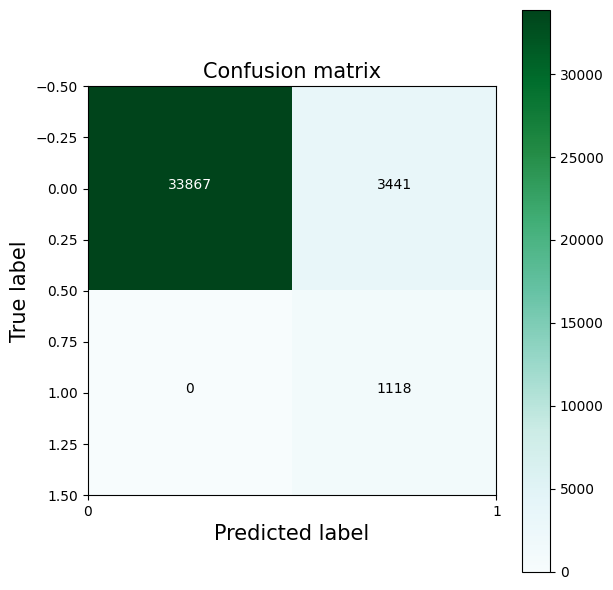

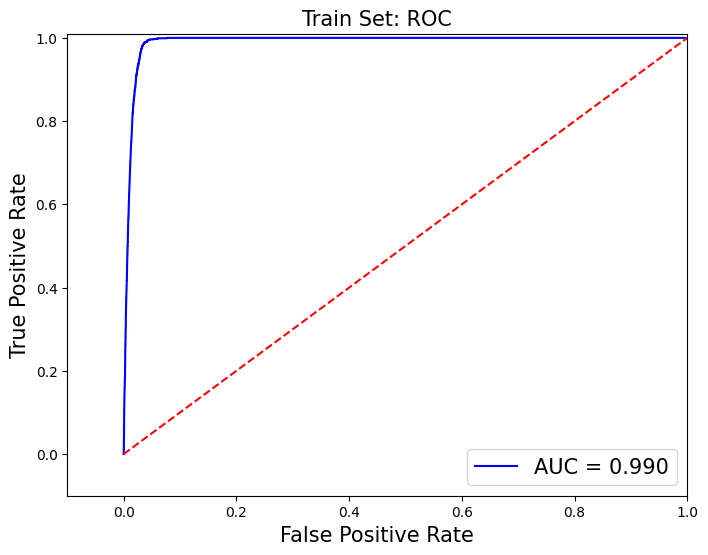

************** Performance: Test Set **************** 

Accuracy: 0.87
Precision: 0.06
Recall: 0.25
F1: 0.1


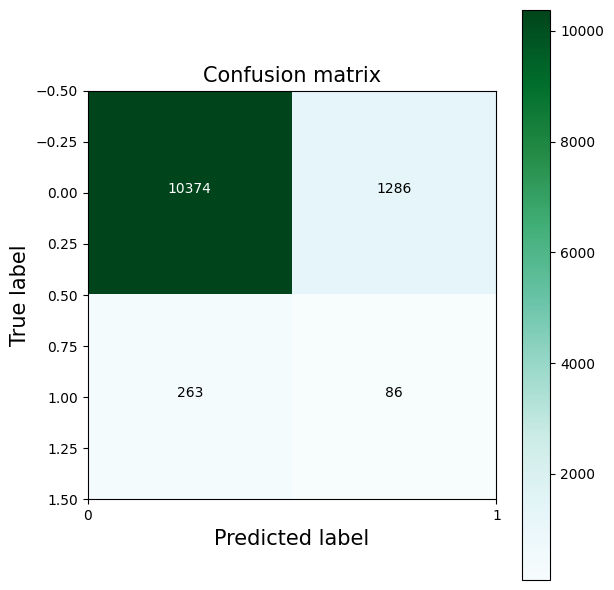

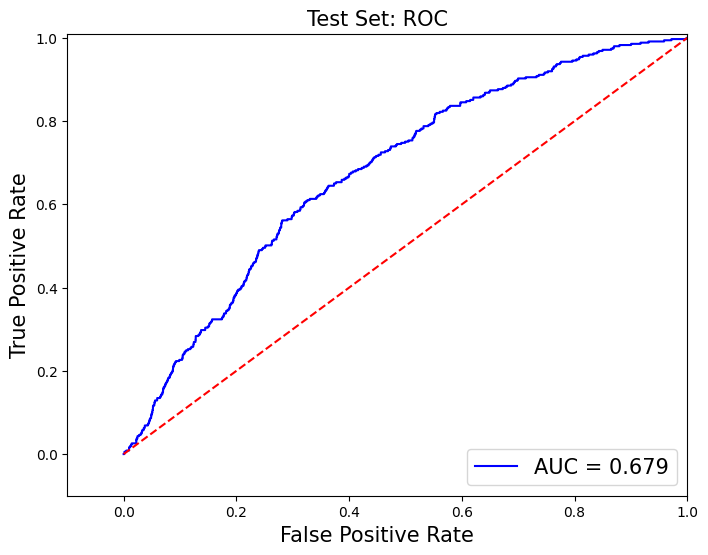

In [35]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [99]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


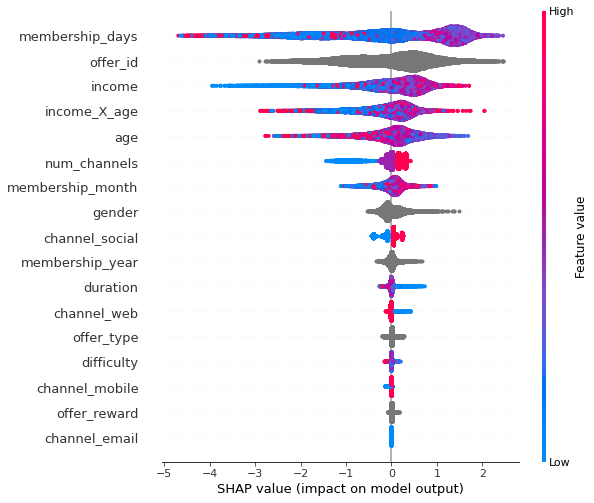

In [100]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)
